In [1]:
# import libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# read in data, taking 10% sample
p = .1
required_cols = ['JobID','Partition', 'Account', 'Group', 'GID',
       'User', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed',
       'ExitCode', 'State', 'NNodes', 'NCPUS', 'ReqCPUS', 'ReqMem', 'ReqGRES',
       'ReqTRES', 'Timelimit', 'NodeList', 'JobName']
accre = pd.read_csv('data/accre_data.txt', header=0, sep='|', usecols=required_cols, skiprows=lambda i: i>0 and random.random() > p)

## DISCOVERY

In [2]:
accre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1249154 entries, 0 to 1249153
Data columns (total 22 columns):
JobID        1249154 non-null object
Partition    1238295 non-null object
Account      1249154 non-null object
Group        1249154 non-null object
GID          1249154 non-null int64
User         1249154 non-null object
Submit       1249154 non-null object
Eligible     1249154 non-null object
Start        1249154 non-null object
End          1249154 non-null object
Elapsed      1249154 non-null object
ExitCode     1249154 non-null object
State        1249154 non-null object
NNodes       1249154 non-null int64
NCPUS        1249154 non-null int64
ReqCPUS      1249154 non-null int64
ReqMem       1249154 non-null object
ReqGRES      8421 non-null object
ReqTRES      1238295 non-null object
Timelimit    1238295 non-null object
NodeList     1249154 non-null object
JobName      1249153 non-null object
dtypes: int64(4), object(18)
memory usage: 209.7+ MB


In [3]:
# look at the shape of the dataset
accre.shape

(1249154, 22)

## CLEANUP

In [4]:
# convert partition & account to category
accre.Partition = accre.Partition.astype('category')
accre.Account = accre.Account.astype('category')
accre.dtypes

JobID          object
Partition    category
Account      category
Group          object
GID             int64
User           object
Submit         object
Eligible       object
Start          object
End            object
Elapsed        object
ExitCode       object
State          object
NNodes          int64
NCPUS           int64
ReqCPUS         int64
ReqMem         object
ReqGRES        object
ReqTRES        object
Timelimit      object
NodeList       object
JobName        object
dtype: object

In [5]:
# convert Submit and Start to datetime
accre['Submit'] = pd.to_datetime(accre['Submit'], format='%Y/%m/%d')
accre['Start'] = pd.to_datetime(accre['Start'], format='%Y/%m/%d')

In [6]:
# create Queue_Time column = Start - Submit
accre['Queue_Time'] = accre['Start'] - accre['Submit']
accre.Queue_Time.head()

0   1 days 01:33:01
1   0 days 00:00:02
2   0 days 00:00:01
3   0 days 00:00:01
4   0 days 00:01:43
Name: Queue_Time, dtype: timedelta64[ns]

In [7]:
# check data types
accre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1249154 entries, 0 to 1249153
Data columns (total 23 columns):
JobID         1249154 non-null object
Partition     1238295 non-null category
Account       1249154 non-null category
Group         1249154 non-null object
GID           1249154 non-null int64
User          1249154 non-null object
Submit        1249154 non-null datetime64[ns]
Eligible      1249154 non-null object
Start         1249154 non-null datetime64[ns]
End           1249154 non-null object
Elapsed       1249154 non-null object
ExitCode      1249154 non-null object
State         1249154 non-null object
NNodes        1249154 non-null int64
NCPUS         1249154 non-null int64
ReqCPUS       1249154 non-null int64
ReqMem        1249154 non-null object
ReqGRES       8421 non-null object
ReqTRES       1238295 non-null object
Timelimit     1238295 non-null object
NodeList      1249154 non-null object
JobName       1249153 non-null object
Queue_Time    1249154 non-null timedel

In [8]:
# head data exploration for each column
for column in list(accre.columns):
    print(accre[column].value_counts(normalize=False,ascending=False).head(10))
    print('')
    print('')
    

26764369_4      2
26874186        2
19224428_114    2
26749987_44     2
26764369_65     2
26764369_79     2
19052765        2
26749987_25     2
26827147_1      2
20581315        1
Name: JobID, dtype: int64


production    1229226
pascal           5784
maxwell          3176
debug              62
bigbox             24
mic                23
Name: Partition, dtype: int64


cms                  353684
beam_lab             144452
cms_lowprio           92825
p_csb_meiler          76376
cms_stage2            66479
mip_eecs              57010
h_biostat_student     44935
lola                  44398
p_meiler              42792
math                  37015
Name: Account, dtype: int64


cms                  506565
beam_lab             149548
p_csb_meiler          73776
mip_eecs              57157
p_meiler              45702
cms_stage1            45634
lola                  45179
h_biostat_student     44892
math                  37017
rokaslab              30257
Name: Group, dtype: int64


31000    5

## BEGIN WORK ON QUESTION

In [21]:
#get count of status
state_messages = accre.State.value_counts().to_frame().reset_index()
state_messages.columns = ["status","count"]
state_messages.head(20)


,status,count
0,COMPLETED,714625
1,CANCELLED by 29607,335130
2,FAILED,90250
3,CANCELLED by 29605,35642
4,TIMEOUT,16078
5,CANCELLED by 112888,10461
6,CANCELLED by 233674,6470
7,CANCELLED by 207302,4507
8,CANCELLED by 0,3017
9,CANCELLED by 551122,2481


In [22]:
#group cancelled statuses
import re
condition = re.compile("CANCELLED by\s\d*")
state_messages['status'] = state_messages.status.replace(to_replace=condition,value="CANCELLED")
state_messages.groupby("status")["count"].sum().to_frame().reset_index()

,status,count
0,CANCELLED,426587
1,COMPLETED,714625
2,FAILED,90250
3,NODE_FAIL,225
4,PREEMPTED,1389
5,TIMEOUT,16078


In [11]:
# get jobs run per node (count of JobID grouped by NodeList)
jobs_per_node = accre.groupby('NodeList').JobID.count().to_frame().sort_values(by="JobID",ascending=False).iloc[1:,:]
jobs_per_node.rename({"JobID":"JobRuns"},axis=1)

,JobRuns
NodeList,
vmp1409,9127
vmp1242,7934
vmp1257,7419
vmp1001,6486
vmp1298,4771
vmp1003,3828
vmp1061,3721
vmp1010,3692
vmp1002,3678


In [32]:
#jobs failed per node (count of JobID grouped by NodeList from )
state_failed = ['NODE_FAIL']
state_bad = accre.loc[accre['State'].isin(state_failed)]
fails_per_node = state_bad.groupby('NodeList').JobID.count().to_frame().sort_values("JobID",ascending=False)
fails_per_node.head()

,JobID
NodeList,
vmp598,4
vmp1352,4
vmp1354,4
vmp1047,4
vmp1350,3


In [47]:
#merge jobs run and jobs failed
node_fails_table = pd.merge(jobs_per_node,fails_per_node,on='NodeList',how='left')
node_fails_table = node_fails_table.rename({'JobID_x':'JobRuns','JobID_y':'JobFails'},axis=1)
node_fails_table.head()

,JobRuns,JobFails
NodeList,,
vmp1409,9127,NaN
vmp1242,7934,NaN
vmp1257,7419,NaN
vmp1001,6486,NaN
vmp1298,4771,NaN


In [46]:
#drop rows missing data
##should first check how many rows that will be
node_fails_table = node_fails_table.dropna()

#create Fail% column & sort
node_fails_table['Fail%'] = node_fails_table.JobFails/node_fails_table.JobRuns
node_fails_table.sort_values(by='JobRuns', ascending=False)


AttributeError: 'list' object has no attribute 'dropna'

In [15]:
#drop rows with no jobs failed or <100 jobs run
condition1 = node_fails_table.JobFails != 0
condition2 = node_fails_table.JobRuns > 100

node_fails_table = node_fails_table[condition1&condition2]

In [16]:
#show sorted table
node_fails_table = node_fails_table.sort_values(by='Fail%',ascending=False)
node_fails_table

,NodeList,JobRuns,JobFails,Fail%
627,vmp598,115,4.0,0.034783
629,vmp698,111,2.0,0.018018
631,gpu0010,105,1.0,0.009524
628,vmp592,112,1.0,0.008929
626,gpu0007,116,1.0,0.008621
623,vmp692,121,1.0,0.008264
621,vmp696,129,1.0,0.007752
620,gpu0012,139,1.0,0.007194
617,gpu0008,173,1.0,0.005780
615,gpu0011,208,1.0,0.004808


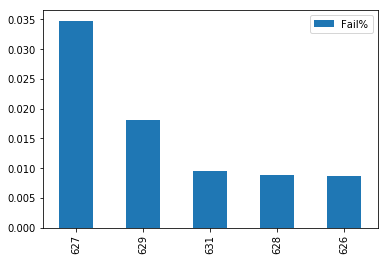

In [17]:
#barplot of top 5 
node_fails_table[["Fail%"]].iloc[0:5,:].plot(kind="bar")